In [1]:
# packages

import numpy as np
import pandas as pd

In [55]:
FEE_HAIRCUT = 0.997
EXCHANGES = [
    {"input_token": 1, "input_liquidity": 2.1, "output_token": 2, "output_liquidity": 3.2, "haircut": FEE_HAIRCUT},
    {"input_token": 2, "input_liquidity": 2.2, "output_token": 3, "output_liquidity": 3.3, "haircut": FEE_HAIRCUT},
    {"input_token": 3, "input_liquidity": 2.3, "output_token": 4, "output_liquidity": 3.4, "haircut": FEE_HAIRCUT},
    {"input_token": 4, "input_liquidity": 2.4, "output_token": 1, "output_liquidity": 3.5, "haircut": FEE_HAIRCUT}, ]


In [104]:
SWAP_CURVE_X = np.exp(np.linspace(0, 1, 100)) - 1
#print(SWAP_CURVE_X)

In [105]:
# Define forward and backward swap calculators
from typing import Union

def forward_swap(x:Union[float, np.ndarray], haircut:float = FEE_HAIRCUT) -> Union[float, np.ndarray]:
    if isinstance(x, float):
        assert x >= 0
    elif isinstance(x, np.ndarray):
        assert np.all(x) >= 0
    assert haircut > 0
    return haircut * x /(1 + haircut * x)

def backward_swap(y:Union[float, np.ndarray], haircut:float = FEE_HAIRCUT) -> Union[float, np.ndarray]:
    if isinstance(y, float):
        assert y >= 0.0
        assert y < 1.0
    elif isinstance(y, np.ndarray):
        assert np.all(y) >= 0
        assert np.all(y < 1.0)
    assert haircut > 0
    return y /(haircut - haircut * y)



In [106]:
def generate_ITL(exchange_list:list[dict]=EXCHANGES) -> dict:
    ITL = {}
    ITL[1] = {'token': 1, 'current_in_liq': exchange_list[0]['input_liquidity']}
    for i in range(len(exchange_list)-1):
        assert exchange_list[i]['output_token'] == exchange_list[i+1]['input_token']
        token = exchange_list[i]['output_token']
        ITL[token] = {'token': token,
                      "prior_out_liq": exchange_list[i]['output_liquidity'],
                      "current_in_liq": exchange_list[i+1]['input_liquidity'],
                      "current_out_liq": exchange_list[i+1]['output_liquidity'],}
    return ITL



In [107]:
ITL = generate_ITL()
print(ITL)
exchange_list = EXCHANGES

{1: {'token': 1, 'current_in_liq': 2.1}, 2: {'token': 2, 'prior_out_liq': 3.2, 'current_in_liq': 2.2, 'current_out_liq': 3.3}, 3: {'token': 3, 'prior_out_liq': 3.3, 'current_in_liq': 2.3, 'current_out_liq': 3.4}, 4: {'token': 4, 'prior_out_liq': 3.4, 'current_in_liq': 2.4, 'current_out_liq': 3.5}}


In [108]:
# Define swap curves
x_curve = SWAP_CURVE_X
y_curve = forward_swap(x_curve)
test_x_curve = backward_swap(y_curve)

# Check if forward_swap equals inverse of backward_swap
inverse_test = np.allclose(x_curve, test_x_curve)
print(f"Swap curves defined. \nForward and Backward are inverses: {inverse_test}")

Swap curves defined. 
Forward and Backward are inverses: True


In [109]:

def recursive_step( eta:Union[float, np.ndarray], itl:dict, x:np.array, y:np.array) -> (Union[float, np.ndarray],Union[float, np.ndarray]):
    delta_ = eta * itl['prior_out_liq']
    ratio = itl['prior_out_liq'] / itl['current_in_liq']
    dsw_ = eta * ratio                                   # Discrete swap argument: eta * (a_{j,j-1}/a_{j,j+1})
    xi_ = np.searchsorted(x, dsw_, side='right')         # x[xi_] > X
    eta_ = y[xi_]
    return delta_, eta_

In [126]:
# Compute swaps for all points in x_curve

x_curve = np.linspace(0.0, 1.2, 10)
y_curve = forward_swap(x_curve)
delta_1 = x_curve * exchange_list[0]['input_liquidity']

delta_2 = exchange_list[0]['output_liquidity'] * y_curve #forward_swap(delta_1/exchange_list[0]['input_liquidity'])
delta_3 = exchange_list[1]['output_liquidity'] * forward_swap(delta_2/exchange_list[1]['input_liquidity'])
delta_4 = exchange_list[2]['output_liquidity'] * forward_swap(delta_3/exchange_list[2]['input_liquidity'])
delta_1_prime = exchange_list[3]['output_liquidity'] * forward_swap(delta_4/exchange_list[3]['input_liquidity'])

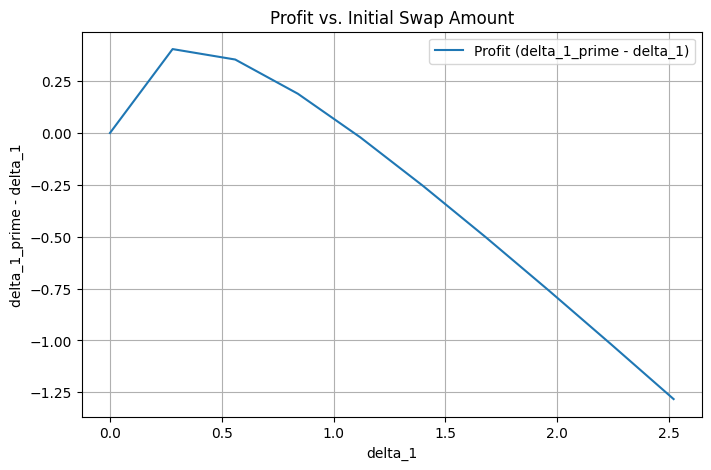

In [127]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(delta_1, delta_1_prime - delta_1, label="Profit (delta_1_prime - delta_1)")
plt.xlabel("delta_1")
plt.ylabel("delta_1_prime - delta_1")
plt.title("Profit vs. Initial Swap Amount")
plt.legend()
plt.grid(True)
plt.show()

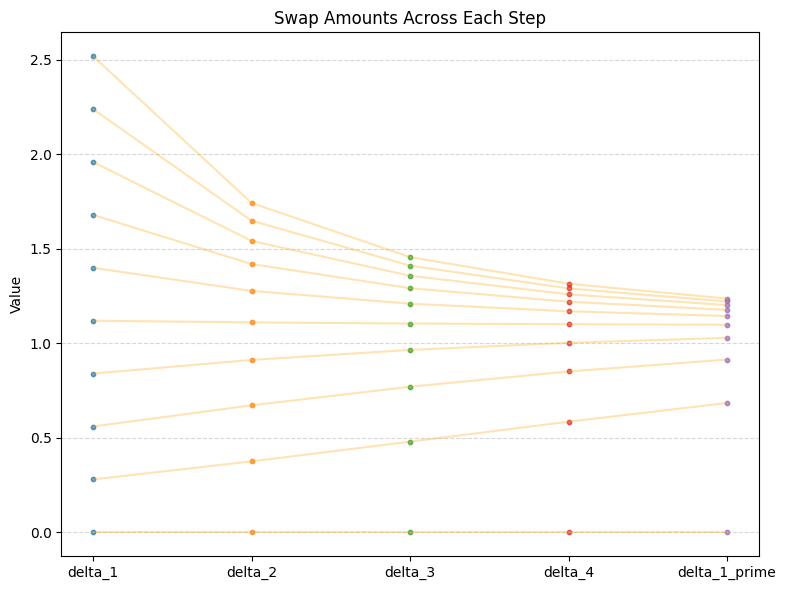

In [128]:
# Prepare the arrays and labels
swap_arrays = [delta_1, delta_2, delta_3, delta_4, delta_1_prime]
labels = ["delta_1", "delta_2", "delta_3", "delta_4", "delta_1_prime"]

plt.figure(figsize=(8, 6))
for i, arr in enumerate(swap_arrays):
    sorted_arr = np.sort(arr)
    plt.scatter([i]*len(sorted_arr), sorted_arr, s=10, alpha=0.7)


# Draw lines connecting delta_1[i], delta_2[i], ..., delta_1_prime[i] for each i
for i in range(len(delta_1)):
    y = [arr[i] for arr in swap_arrays]
    x = list(range(len(swap_arrays)))
    plt.plot(x, y, color='orange', alpha=0.3)
plt.xticks(range(len(labels)), labels)
plt.ylabel("Value")
plt.title("Swap Amounts Across Each Step")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [122]:

# Recursive compute

# define token variable outside loop to use below
token = 0

for itl in ITL:
    # load ITL for the current iteration
    current = ITL[itl]
    token = current['token']

    if token == 1:
        # initial step:
        #     delta_1 = x_curve * a_{1,2}
        #     eta_1   = y_curve
        current['delta'] , current['eta'] = x_curve * current['current_in_liq'] , y_curve
        delta_1 = current['delta']
    else:
        # recursion
        prior = ITL[itl-1]                           # recursion
        current['delta'] , current['eta'] = recursive_step(prior['eta'], current, x_curve, y_curve)

delta_1_prime = ITL[token]['eta'] * ITL[token]['current_out_liq']


In [114]:
profit = delta_1_prime - delta_1

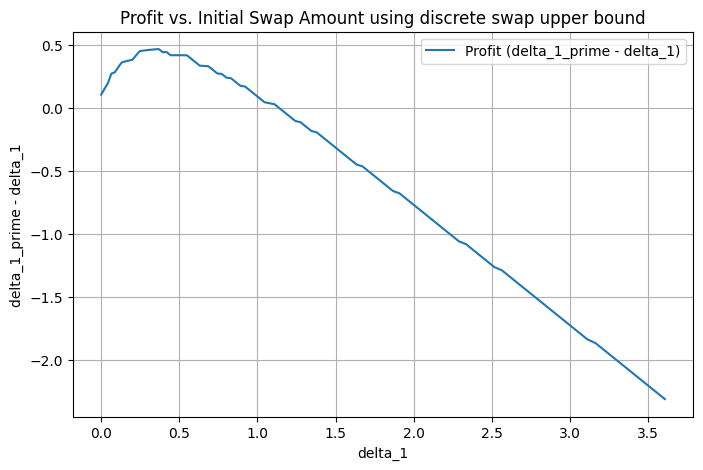

In [115]:
plt.figure(figsize=(8, 5))
plt.plot(delta_1, profit, label="Profit (delta_1_prime - delta_1)")
plt.xlabel("delta_1")
plt.ylabel("delta_1_prime - delta_1")
plt.title("Profit vs. Initial Swap Amount using discrete swap upper bound")
plt.legend()
plt.grid(True)
plt.show()

In [293]:

for i in range(len(x_curve)):
    if delta_1[i] == 0.0:
        continue
    rtn = profit[i] / delta_1[i]
    print(f" delta_1: {delta_1[i]:10.8f} profit: {profit[i]:10.8f} return: {rtn:10.8f} ")


 delta_1: 0.02131961 profit: 0.13092255 return: 6.14094365 
 delta_1: 0.04285567 profit: 0.16817485 return: 3.92421463 
 delta_1: 0.06461036 profit: 0.23241764 return: 3.59721918 
 delta_1: 0.08658592 profit: 0.23853678 return: 2.75491428 
 delta_1: 0.10878457 profit: 0.27168775 return: 2.49748428 
 delta_1: 0.13120859 profit: 0.30351217 return: 2.31320358 
 delta_1: 0.15386026 profit: 0.30757860 return: 1.99907766 
 delta_1: 0.17674189 profit: 0.31114791 return: 1.76046499 
 delta_1: 0.19985582 profit: 0.31422042 return: 1.57223551 
 delta_1: 0.22320441 profit: 0.34246173 return: 1.53429639 
 delta_1: 0.24679004 profit: 0.36943924 return: 1.49697789 
 delta_1: 0.27061512 profit: 0.37051707 return: 1.36916619 
 delta_1: 0.29468207 profit: 0.37110394 return: 1.25933665 
 delta_1: 0.31899336 profit: 0.37119985 return: 1.16366013 
 delta_1: 0.34355146 profit: 0.37080480 return: 1.07932827 
 delta_1: 0.36835887 profit: 0.36991870 return: 1.00423453 
 delta_1: 0.39341814 profit: 0.34485943 

In [255]:
# Exchange 2 -> 3
token_flow = exchange_list[0]['output_token']
token_in = exchange_list[1]['input_token']
assert token_flow == token_in
intermediate_token_liquidity = ITL[token_flow]
print(f"Token liquidity for token-{token_flow} = {intermediate_token_liquidity}")

delta_2, eta_2 = recursive_step(eta_1, intermediate_token_liquidity, x_curve, y_curve)

#for i in range(len(x_curve)):
    # print(f"{i} xi: {x_curve[xi_indx[i]]:6.4f},  X_2: {X_2[i]:6.4f}, xi_indx: {xi_indx[i]} ")
#    print(f"{i} delta_2: {delta_2[i]:6.4f},  eta_2: {eta_2[i]:6.4f}")


Token liquidity for token-2 = {'out_liq': 3.2, 'in_liq': 2.2}


In [254]:
_, eta_2_test = recursive_step(eta_1, intermediate_token_liquidity, x_curve, y_curve)

assert np.allclose(eta_2, eta_2_test)

In [220]:
# Exchange 3 -> 4
token_flow = exchange_list[1]['output_token']
token_out = exchange_list[2]['input_token']

assert token_flow == token_out
intermediate_token_liquidity = ITL[token_flow]
print(f"Token liquidity for token-{token_flow} = {intermediate_token_liquidity}")

X_3 = eta_2 * intermediate_token_liquidity                 # Discrete swap argument: eta_2 * (a_{3,2}/a_{3,4})

xi_indx = np.searchsorted(x_curve, X_3, side='right')      # x_curve[xi_indx] > X_2
eta_3 = y_curve[xi_indx]
delta_4 = eta_3 * exchange_list[2]['output_liquidity']

for i in range(len(x_curve)):
    if xi_indx[i] == len(x_curve):
        xi_indx -= 1
    #print(f"{i} xi: {x_curve[xi_indx[i]]:6.4f},  X_3: {X_3[i]:6.4f}, xi_indx: {xi_indx[i]} ")
    print(f"{i} delta_4: {delta_4[i]:6.4f},  eta_3: {eta_3[i]:6.4f}")


Token liquidity for token-3 = 1.434782608695652
0 delta_4: 0.0678,  eta_3: 0.0199
1 delta_4: 0.1012,  eta_3: 0.0298
2 delta_4: 0.1670,  eta_3: 0.0491
3 delta_4: 0.2315,  eta_3: 0.0681
4 delta_4: 0.2632,  eta_3: 0.0774
5 delta_4: 0.3258,  eta_3: 0.0958
6 delta_4: 0.3871,  eta_3: 0.1139
7 delta_4: 0.4173,  eta_3: 0.1227
8 delta_4: 0.4472,  eta_3: 0.1315
9 delta_4: 0.4768,  eta_3: 0.1402
10 delta_4: 0.5351,  eta_3: 0.1574
11 delta_4: 0.5923,  eta_3: 0.1742
12 delta_4: 0.6204,  eta_3: 0.1825
13 delta_4: 0.6483,  eta_3: 0.1907
14 delta_4: 0.6759,  eta_3: 0.1988
15 delta_4: 0.7032,  eta_3: 0.2068
16 delta_4: 0.7302,  eta_3: 0.2148
17 delta_4: 0.7302,  eta_3: 0.2148
18 delta_4: 0.7570,  eta_3: 0.2226
19 delta_4: 0.7835,  eta_3: 0.2304
20 delta_4: 0.8097,  eta_3: 0.2382
21 delta_4: 0.8357,  eta_3: 0.2458
22 delta_4: 0.8614,  eta_3: 0.2534
23 delta_4: 0.8869,  eta_3: 0.2608
24 delta_4: 0.8869,  eta_3: 0.2608
25 delta_4: 0.8869,  eta_3: 0.2608
26 delta_4: 0.9121,  eta_3: 0.2683
27 delta_4: 0.937

In [221]:
# Exchange 4 -> 1
token_flow = exchange_list[2]['output_token']
token_out = exchange_list[3]['input_token']

assert token_flow == token_out
intermediate_token_liquidity = ITL[token_flow]
print(f"Token liquidity for token-{token_flow} = {intermediate_token_liquidity}")

X_4 = eta_3 * intermediate_token_liquidity                 # Discrete swap argument: eta_3 * (a_{4,3/a_{4,1})

xi_indx = np.searchsorted(x_curve, X_4, side='right')      # x_curve[xi_indx] > X_2
eta_4 = y_curve[xi_indx]
delta_1_prime = eta_4 * exchange_list[3]['output_liquidity']
for i in range(len(x_curve)):
    if xi_indx[i] == len(x_curve):
        xi_indx -= 1
    #print(f"{i} xi: {x_curve[xi_indx[i]]:6.4f},  X_3: {X_4[i]:6.4f}, xi_indx: {xi_indx[i]} ")
    print(f"{i} delta_1_prime: {delta_1_prime[i]:6.4f},  eta_4: {eta_4[i]:6.4f}")


Token liquidity for token-4 = 1.4166666666666667
0 delta_1_prime: 0.0923,  eta_4: 0.0298
1 delta_1_prime: 0.1522,  eta_4: 0.0491
2 delta_1_prime: 0.2110,  eta_4: 0.0681
3 delta_1_prime: 0.2970,  eta_4: 0.0958
4 delta_1_prime: 0.3251,  eta_4: 0.1049
5 delta_1_prime: 0.3805,  eta_4: 0.1227
6 delta_1_prime: 0.4347,  eta_4: 0.1402
7 delta_1_prime: 0.4614,  eta_4: 0.1489
8 delta_1_prime: 0.4879,  eta_4: 0.1574
9 delta_1_prime: 0.5141,  eta_4: 0.1658
10 delta_1_prime: 0.5657,  eta_4: 0.1825
11 delta_1_prime: 0.6162,  eta_4: 0.1988
12 delta_1_prime: 0.6411,  eta_4: 0.2068
13 delta_1_prime: 0.6658,  eta_4: 0.2148
14 delta_1_prime: 0.6902,  eta_4: 0.2226
15 delta_1_prime: 0.7144,  eta_4: 0.2304
16 delta_1_prime: 0.7383,  eta_4: 0.2382
17 delta_1_prime: 0.7383,  eta_4: 0.2382
18 delta_1_prime: 0.7620,  eta_4: 0.2458
19 delta_1_prime: 0.7620,  eta_4: 0.2458
20 delta_1_prime: 0.7854,  eta_4: 0.2534
21 delta_1_prime: 0.8086,  eta_4: 0.2608
22 delta_1_prime: 0.8316,  eta_4: 0.2683
23 delta_1_prime: 

In [222]:
profit = delta_1_prime - delta_1

for i in range(len(x_curve)):
    if delta_1[i] == 0.0:
        continue
    rtn = profit[i] / delta_1[i]
    print(f" delta_1: {delta_1[i]:10.8f} profit: {profit[i]:10.8f} return: {rtn:10.8f} ")


 delta_1: 0.02131961 profit: 0.13092255 return: 6.14094365 
 delta_1: 0.04285567 profit: 0.16817485 return: 3.92421463 
 delta_1: 0.06461036 profit: 0.23241764 return: 3.59721918 
 delta_1: 0.08658592 profit: 0.23853678 return: 2.75491428 
 delta_1: 0.10878457 profit: 0.27168775 return: 2.49748428 
 delta_1: 0.13120859 profit: 0.30351217 return: 2.31320358 
 delta_1: 0.15386026 profit: 0.30757860 return: 1.99907766 
 delta_1: 0.17674189 profit: 0.31114791 return: 1.76046499 
 delta_1: 0.19985582 profit: 0.31422042 return: 1.57223551 
 delta_1: 0.22320441 profit: 0.34246173 return: 1.53429639 
 delta_1: 0.24679004 profit: 0.36943924 return: 1.49697789 
 delta_1: 0.27061512 profit: 0.37051707 return: 1.36916619 
 delta_1: 0.29468207 profit: 0.37110394 return: 1.25933665 
 delta_1: 0.31899336 profit: 0.37119985 return: 1.16366013 
 delta_1: 0.34355146 profit: 0.37080480 return: 1.07932827 
 delta_1: 0.36835887 profit: 0.36991870 return: 1.00423453 
 delta_1: 0.39341814 profit: 0.34485943 